In [1]:
%pylab inline
import math
import polyline
import itertools
import pandas as pd
import pylab as plt
from glob import glob
import seaborn as sns
from itertools import cycle
from scipy.optimize import curve_fit
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans,AgglomerativeClustering
# --------------------------------------------------------
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

def get_df(test):
    rawdf = pd.read_pickle('../data/{0:s}_latest.pdpkl'.format(test))
    return rawdf

prj = 1
tests = ['inside','outin','bigpar']
N_CLUSTERS = [8,10,10][prj] # 10 for test 0
BOUNDARIES = [(250000,270000,6210000,6227000),
              (245000,275000,6205000,6235000),
              (245000,275500,6200000,6235000)][prj]
df = get_df(tests[prj])
TITLE = tests[prj]

!mkdir plots/

Populating the interactive namespace from numpy and matplotlib
mkdir: cannot create directory ‘plots/’: File exists


## kg CO<sub>2</sub> production

In [2]:
raw_co2_car = 0.35 #kgc02/mile/passenger -- 2 ways
raw_co2_transit = 0.121 #kgco2/mile/passenger -- 2 ways

#convert to km per 1 way
mileperkm = 1.60934**-1
co2_car = raw_co2_car *mileperkm /2.
co2_transit = raw_co2_transit *mileperkm /2.
co2_bike    = 21./1000. #21g/km
print co2_car
print co2_transit
print co2_bike

0.108740228914
0.0375930505673
0.021


In [3]:
# data['velocity']=data['distance']/data['duration']
# data['velocity_hsin']=data['haversine_distance']/data['duration']
# data['dratio']=data['distance']/data['haversine_distance']
df['co2kg']=df['distance']
df.loc[df['mode']=='driving','co2kg'] *= co2_car/1000.
df.loc[df['mode']=='transit','co2kg'] *= co2_transit/1000. # To meters
df.loc[df['mode']=='bicycling','co2kg'] *= co2_bike/1000. # To meters

## Compute coupled and fast trips 
bcs I didn't decide yet where to save this df

In [4]:
def get_coupled_trips_relative_speed(mode1,mode2,df):    
    """ compatibility function to get this stuff from the data"""
    
    # selection receipt
    cpd = df[df.coupled>0]
    row_mode1 = cpd[cpd['mode']==mode1]
    row_mode2 = cpd[cpd['mode']==mode2]
    return row_mode1,row_mode2,df

bicycling,driving,df=get_coupled_trips_relative_speed('bicycling','driving',df=df)

bike = bicycling[bicycling.bicycling_faster_driving==1]
car  = driving[driving.bicycling_faster_driving==0]

nobike = bicycling[bicycling.bicycling_faster_driving==0]
nocar  = driving[driving.bicycling_faster_driving==1]



In [5]:
bicycling.shape,driving.shape,bike.shape

((22967, 16), (22967, 16), (1017, 16))

In [6]:
df.groupby(('mode','kind')).count()

departure  distance  duration  haversine_distance      p1  \
mode      kind                                                              
bicycling full      22967     22967     22967               22967   22967   
          step     172780    172780    172780              172780  172780   
driving   full      22967     22967     22967               22967   22967   
          step     147916    147916    147916              147916  147916   
transit   full      22967     22967     22967               22967   22967   
          step      28033     28033     28033               28033   28033   
walking   step      49419     49419     49419               49419   49419   

                    p2  polyline  walk_distance  duration[m]  distance[km]  \
mode      kind                                                               
bicycling full   22967     22967              0        22967         22967   
          step  172780         0              0       172780        172780   
driving   full   22967     22967              0        22967         22967   
          step  147916         0              0       147916        147916   
transit   full   22967     22967              0        22967         22967   
          step   28033         0              0        28033         28033   
walking   step   49419         0              0        49419         49419   

                coupled  bicycling_faster_driving    same   co2kg  
mode      kind                                                     
bicycling full    22967                     22967   22967   22967  
          step   172780                    172780  172780  172780  
driving   full    22967                     22967   22967   22967  
          step   147916                    147916  147916  147916  
transit   full    22967                     22967   22967   22967  
          step    28033                     28033   28033   28033  
walking   step    49419                     49419   49419   49419

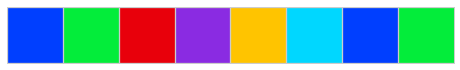

In [7]:
sns.palplot(sns.color_palette('bright',8))

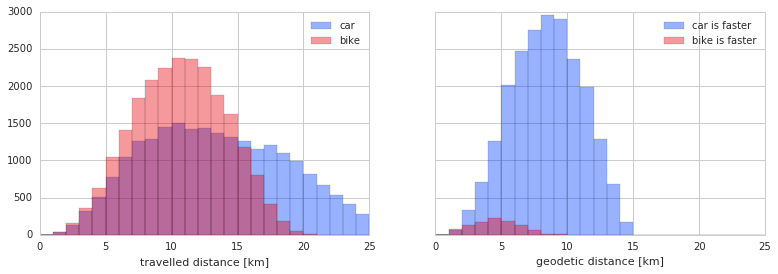

In [8]:
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_palette('bright')
b1 = sns.color_palette('bright')[0]
b2 = sns.color_palette('bright')[2]
fig,(ax,bx)=plt.subplots(1,2,figsize=(13,4),sharex='all',sharey='all')
bins=np.arange(0,50,1)
modes = ['bicycling','driving',]

seaborn.distplot(df[(df.kind=='full') & (df['mode']=='driving')]['distance']/1000,color=b1,bins=bins,norm_hist=0,kde=0,ax=ax)
seaborn.distplot(df[(df.kind=='full') & (df['mode']=='bicycling')]['distance']/1000,color=b2,bins=bins,norm_hist=0,kde=0,ax=ax)
seaborn.distplot(car['haversine_distance']/1000,color=b1,bins=bins,kde=0,ax=bx)
seaborn.distplot(bike['haversine_distance']/1000,color=b2,bins=bins,kde=0,ax=bx)

ax.legend(['car','bike'])
bx.legend(['car is faster','bike is faster'])

ax.set_xlabel('travelled distance [km]')
bx.set_xlabel('geodetic distance [km]')
ax.set_xlim(0,25)
fig.savefig('../plots/{0:s}_hist_dist_mode.png'.format(TITLE),bbox_inches='tight',dpi=96)

In [9]:
bins = np.arange(0,26,.5)
digitize_km = lambda x : bins[np.digitize(x,bins=bins)]
bicycling['geo_distance_binned']=(bicycling['haversine_distance']/1000.).map(digitize_km)

max_distance_bin = []
value = []
for i,j in bicycling.groupby('geo_distance_binned'):
    max_distance_bin.append(i)
    value.append(j['bicycling_faster_driving'].sum()*1./j['bicycling_faster_driving'].count())
data_out = np.asarray((max_distance_bin,value))
np.save(open('../data/{0:s}_bikewin_distance.npy'.format(TITLE),'wb'),data_out)

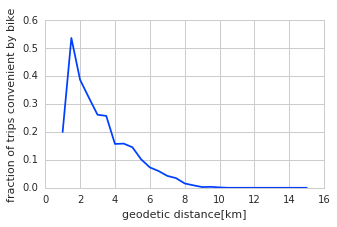

In [10]:
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.plot(max_distance_bin,value)
ax.set_xlabel('geodetic distance[km]')
ax.set_ylabel('fraction of trips convenient by bike')
fig.savefig('../plots/fraction_vs_distance_{0:s}.png'.format(TITLE),bbox_inches='tight',dpi=96)

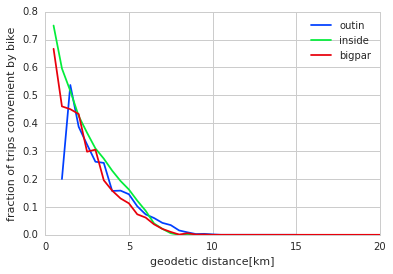

In [11]:
from glob import glob 
files = glob('../data/*_bikewin_distance.npy')
for fin in files:
    max_distance_bin,value = np.load(fin)
    label = fin.split('/')[2].split('_')[0]
    plt.plot(max_distance_bin,value,label=label)
plt.legend()
plt.xlabel('geodetic distance[km]')
plt.ylabel('fraction of trips convenient by bike')

In [12]:
print 'fraction of bikable within 5km:','{0:.2f}'.format(bike[bike.haversine_distance<5000].p1.shape[0]*1./bicycling[bicycling.haversine_distance<5000].p1.shape[0])
print 'fraction of bikable:','{0:.2f}'.format(bike.p1.shape[0]*1./bicycling.p1.shape[0])

fraction of bikable within 5km: 0.20
fraction of bikable: 0.04


## With parking time

In [13]:
import sys;sys.path.append('../')
import lib.dictlist as dl

In [14]:
total_trips = bicycling.shape[0]*1. 

cols = ['coupled','duration']
B = bicycling[cols].values
D = driving[cols].values
z = dl.dictlist(B)
z.update(D)
coupled_durations = np.asarray(z.values()).T

# this function returns the number of bike trips which are faster by bike versus car time + t minutes for parking
# time is stored in 'duration' in seconds
count_fraction_bike_faster_w_parking = lambda t:((coupled_durations[0]-(coupled_durations[1]+t*60))<=0).sum()/total_trips

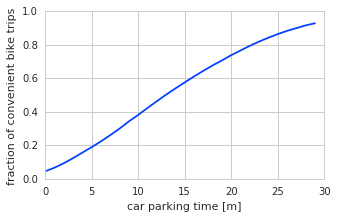

In [15]:
times = xrange(0,30) # minutes
fig,ax=plt.subplots(1,1,figsize=(5,3))
ax.plot(times,map(count_fraction_bike_faster_w_parking,times))
ax.set_xlabel('car parking time [m]')
ax.set_ylabel('fraction of convenient bike trips')
fig.savefig('../plots/on_parking_time_{0:s}.png'.format(TITLE),bbox_inches='tight',dpi=96)

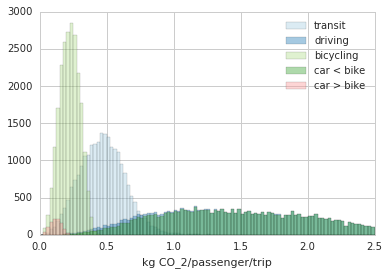

In [16]:
import seaborn

seaborn.set(style='whitegrid')
seaborn.set_palette('Paired')
fig,ax=plt.subplots(1,1)
bins=np.arange(0,3,.025)
modes = ['transit','driving','bicycling']
for mode in modes:
#     data[(data.kind=='full') & (data['mode']==mode)].hist(column='co2kg',ax=ax,sharex=1,
#                                                           bins=bins,alpha=1,cumulative=0,normed=1)
    seaborn.distplot(df[(df.kind=='full') & (df['mode']==mode)]['co2kg'],bins=bins,norm_hist=0,kde=0)
# car.hist(column='co2kg',ax=ax,sharex=1,bins=bins,alpha=1,cumulative=0,normed=0)
seaborn.distplot(car['co2kg'],bins=bins,kde=0)
seaborn.distplot(bike['co2kg'],bins=bins,kde=0)
ax.legend(modes+['car < bike','car > bike'])
ax.set_xlabel('kg CO_2/passenger/trip')
ax.set_xlim(0,2.5)
fig.savefig('../plots/{0:s}_hist_kgco2_mode.png'.format(TITLE),bbox_inches='tight',dpi=96)

In [17]:
co2_all_car    = driving['co2kg'].sum()
co2_car_faster = car['co2kg'].sum()
co2_bike_faster= bike['co2kg'].sum()

print 'car all co2[kg]:',co2_all_car
print 'car <bike co2[kg]:',co2_car_faster
print 'bike<car co2[kg]:', co2_bike_faster
print 'optimal:',co2_car_faster+co2_bike_faster
print '(worse-optimal)/worse:', (co2_all_car-co2_car_faster-co2_bike_faster)/co2_all_car

car all co2[kg]: 34195.4025563
car <bike co2[kg]: 33429.2446748
bike<car co2[kg]: 123.10242
optimal: 33552.3470948
(worse-optimal)/worse: 0.0188053192365
